In [27]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import load_iris
import seaborn as sns
import ruptures as rpt
from scipy.signal import find_peaks
from sklearn.decomposition import PCA as SKPCA

In [ ]:
def PCA(row):
    base = row['dataset']  # like 'b1', 't2', etc.
    
    # Define both front and side keys
    dff = dataframes.get(base + 'f')
    dfs = dataframes.get(base + 's')

    if df is None:
        print(f"Warning: DataFrame for key '{base}' not found.")
        return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])

    try:
        if row['movement'] == 'hand_OC':
            return pd.Series(hand_OC_mov(dfs, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        elif row['movement'] == 'hand_PS':
            return pd.Series(hand_PS_mov(dff, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        elif row['movement'] == 'arm_EF':
            return pd.Series(arm_EF_mov(dff, row['time']), index=['peaks', 'troughs', 'euclidean_dis'])
        else:
            return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])
    except Exception as e:
        print(f"Error processing row {row.name}: {e}")
        return pd.Series([None, None, None], index=['peaks', 'troughs', 'euclidean_dis'])

     bodyparts            PalmBase         PalmBase.1           PalmBase.2  \
0       coords                   x                  y           likelihood   
1            0   427.6842041015625  525.0423583984375  0.14588609337806702   
2            1   427.5551452636719  525.5269775390625   0.1911419928073883   
3            2   428.8374938964844  525.0931396484375  0.17686539888381958   
4            3   427.6429138183594  525.9227905273438   0.1331915706396103   
...        ...                 ...                ...                  ...   
4254      4253   409.2789306640625  529.5111694335938  0.20932647585868835   
4255      4254        410.21484375  528.4324951171875   0.1871751844882965   
4256      4255  409.49407958984375   529.206298828125  0.22666633129119873   
4257      4256   409.3077697753906  529.0945434570312  0.23516501486301422   
4258      4257   409.7013854980469  529.1215209960938   0.1964298039674759   

                    MCP1             MCP1.1               MCP1.

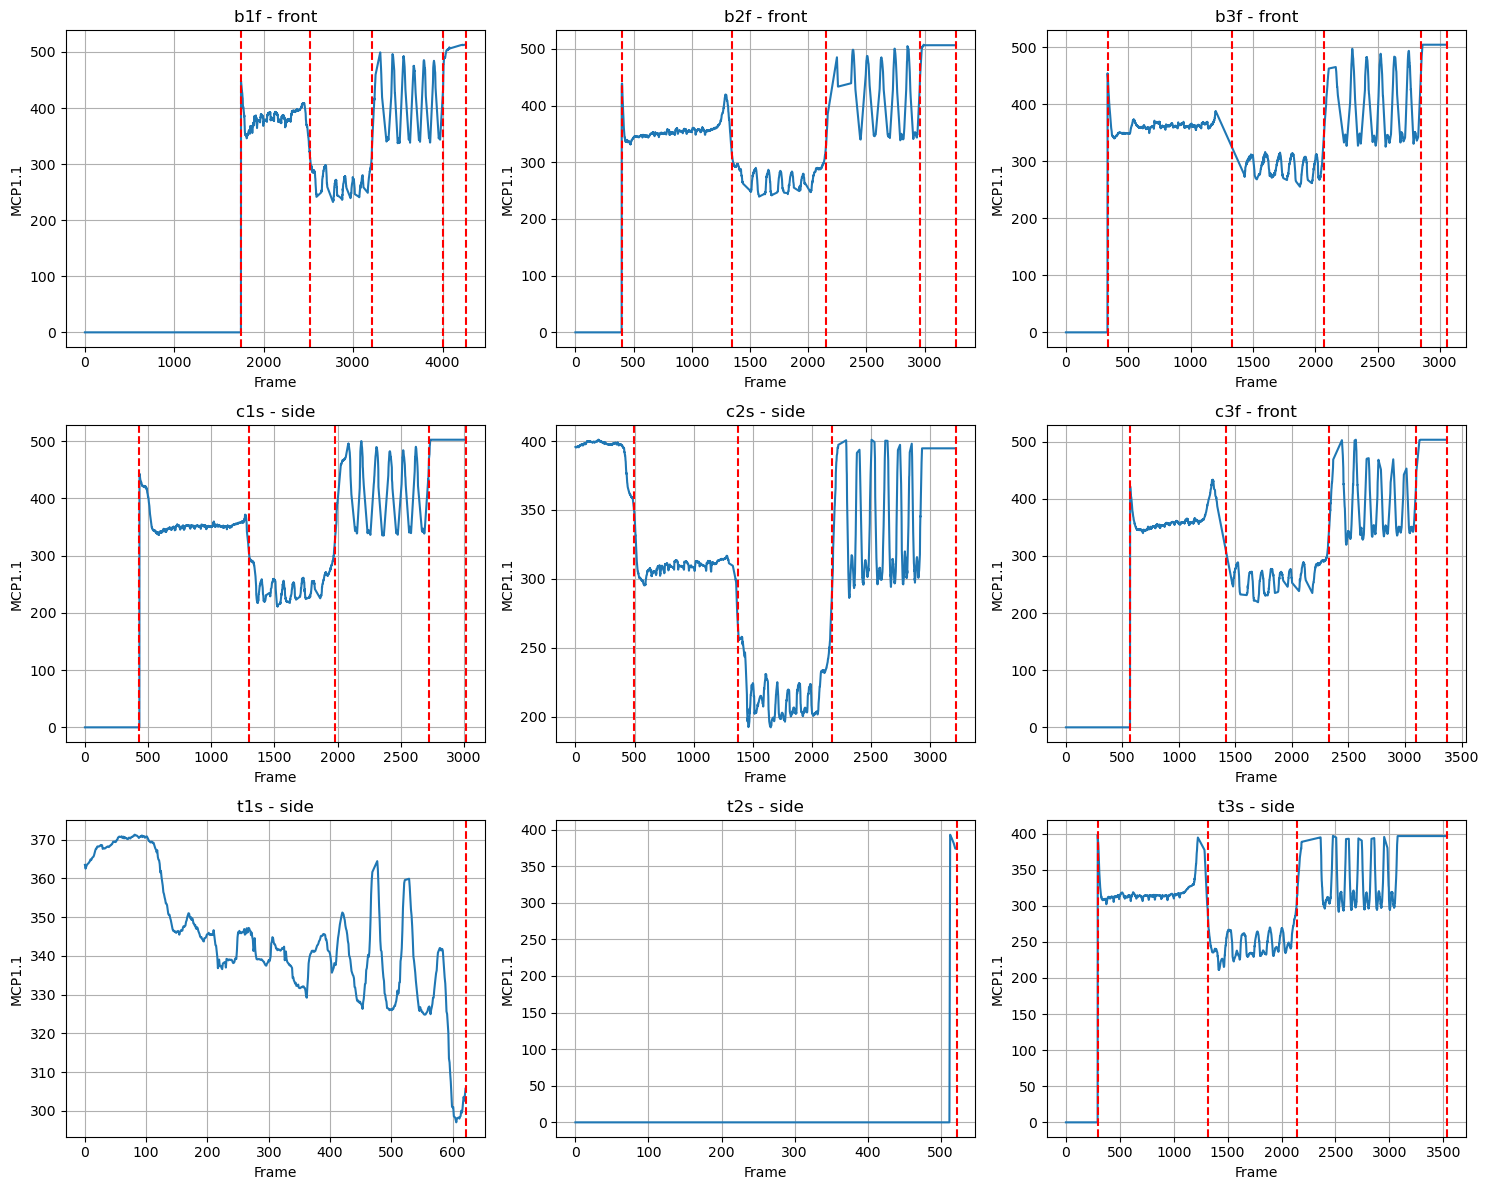

,dataset,movement,data,time,indices
16,c3,hand_PS,"[309.50228428571427, 308.48220842105263, 307.4...","[1416, 1417, 1418, 1419, 1420, 1421, 1422, 142...","(1415, 2325)"
17,c3,arm_EF,"[336.15594, 341.42813, 343.06091, 345.35739, 3...","[2326, 2327, 2328, 2329, 2330, 2331, 2332, 233...","(2325, 3368)"
18,t3,hand_OC,"[398.48032, 393.82822, 391.99323, 391.08386, 3...","[296, 297, 298, 299, 300, 301, 302, 303, 304, ...","(295, 1320)"
19,t3,hand_PS,"[278.54636, 275.8075, 273.53549, 270.30017, 26...","[1321, 1322, 1323, 1324, 1325, 1326, 1327, 132...","(1320, 2140)"
20,t3,arm_EF,"[301.40118, 305.00659, 308.67151, 311.48022, 3...","[2141, 2142, 2143, 2144, 2145, 2146, 2147, 214...","(2140, 3531)"


In [62]:
def convertDF(path): 
    '''converting a dataframe to a new datafrom with float, 5 decimal places and '''

    # reading in file, and skipping top row
    df = pd.read_csv(path, skiprows=1)

    print(df)

    # defining the titles of the rows
    body_loc = df.columns.tolist()

    # creating new empty dataframe
    df_new = pd.DataFrame()


    for part in body_loc:
        if part == 'bodyparts' in part:
            continue
        else:
            df_new[part] = pd.to_numeric(df[part].iloc[1:], errors='coerce').dropna().round(5).astype(float)


    # Copy your DataFrame
    cleaned_df = df_new.copy()

    # Get base marker names by stripping '.1' and '.2'
    marker_names = {'PalmBase', 'MCP1', 'MCP2', 'MCP3', 'MCP4', 'MCP5', 'fTip1', 'fTip2', 'fTip3', 'fTip4', 'fTip5', 'MidForeArm', 'Elbow', 'MidUpperArm'}

    print(marker_names)

    for marker in marker_names:
        x_col = marker
        y_col = marker + '.1'
        l_col = marker + '.2'

        # Phase 1: Find first row where likelihood >= 0.8
        # Boolean mask for where likelihood >= 0.95
        high_likelihood = cleaned_df[l_col] >= 0.95

        # Find where two consecutive values are both True
        consecutive_valid = high_likelihood & high_likelihood.shift(-1, fill_value=False)

        # Get the index of the first such occurrence
        first_valid_idx = consecutive_valid[consecutive_valid].index.min()

        # Remove all rows before first high-confidence point
        cleaned_df.loc[:first_valid_idx - 1, [l_col]] = np.nan

        # Phase 2: Set x/y to NaN where likelihood < 0.95
        low_conf_mask = cleaned_df[l_col] < 0.95
        cleaned_df.loc[low_conf_mask, [x_col, y_col]] = np.nan

        # Interpolate x and y
        cleaned_df[[x_col, y_col]] = cleaned_df[[x_col, y_col]].interpolate(method='linear', limit_direction='both')

        # Phase 3: Set x and y to 0 where likelihood is NaN
        nan_likelihood_mask = cleaned_df[l_col].isna()
        cleaned_df.loc[nan_likelihood_mask, [x_col, y_col]] = 0


    # (Optional) Reset index or drop NaNs if needed
    # cleaned_df = cleaned_df.dropna(subset=marker_names)  # if you want to drop completely bad rows

    # cleaned_df now has cleaned x/y data based on per-marker likelihoods

    cleaned_df


    return cleaned_df

# defining my path to pt one
IO_03_09_2023_RSTN = Path(r'X:\RadcliffeE\for_MorganHampton_BoettcherScholar\Subject Case Data\IO_03_09_2023_RSTN_subject1\Processed DLC\csv folder')

# list of all the videos for this specific patient (c1s is missing for this patient)
dbs_loc = ['b1f', 'b1s', 'b2f', 'b2s', 'b3f', 'b3s', 'c1f', 'c1s', 'c2s', 'c3f', 'c3s', 't1f', 't1s', 't2f', 't2s', 't3f', 't3s']

# place to store all the df
dataframes = {}

files = list(IO_03_09_2023_RSTN.iterdir())

# iterating over each file for pt 1 and converting the df to floats and cleaning up the data
for file, label in zip(IO_03_09_2023_RSTN.iterdir(), dbs_loc):
    dataframes[label] = convertDF(file)
    print(f"{label} loaded from {file.name}")


import pandas as pd
import ruptures as rpt

# Initialize an empty dictionary to hold results by base label
results_dict = {}

for df_name, data in dataframes.items():
    # Extract base label (e.g. 'b1' from 'b1f' or 'b1s')
    base_label = df_name[:-1]  # remove last character
    view = 'front' if df_name.endswith('f') else 'side'

    points = data['MCP1.1']
    points_np = points.to_numpy()

    algo = rpt.Pelt(model='l2').fit(points_np)
    change_points = algo.predict(pen=1e6)

    # Initialize dict entry if not exists
    if base_label not in results_dict:
        results_dict[base_label] = {'front': None, 'side': None}

    # Save change points in proper column
    results_dict[base_label][view] = change_points

# Convert dictionary to DataFrame
df_indices = pd.DataFrame.from_dict(results_dict, orient='index').reset_index()
df_indices.rename(columns={'index': 'dataset'}, inplace=True)

df_indices['front_length'] = df_indices['front'].apply(lambda x: len(x) if isinstance(x, list) else 0)

success_list = []

for _, row in df_indices.iterrows():
    # Check if number of change points in 'front' view is 4 or 5
    num_cp = len(row['front']) if isinstance(row['front'], list) else 0

    if num_cp in [4, 5]:
        success_list.append(f"{row['dataset']}f")
    else:
        success_list.append(f"{row['dataset']}s")

print(success_list)


# Define number of plots per row
plots_per_row = 3
num_plots = len(success_list)
num_rows = int(np.ceil(num_plots / plots_per_row))

# Create a grid of subplots
fig, axes = plt.subplots(num_rows, plots_per_row, figsize=(15, 4 * num_rows))
axes = axes.flatten()  # Make it 1D so it's easier to index

for i, name in enumerate(success_list):
    base_name = name[:-1]
    view = 'front' if name.endswith('f') else 'side'

    # Get signal
    df = dataframes[name]
    signal = df['MCP1.1'].to_numpy()
    time = np.arange(len(signal))

    # Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    change_points = row.iloc[0][view] if not row.empty else []

    # Plot in subplot
    ax = axes[i]
    ax.plot(time, signal, label='MCP1.1')
    for cp in change_points:
        ax.axvline(cp, color='red', linestyle='--')

    ax.set_title(f"{name} - {view}")
    ax.set_xlabel("Frame")
    ax.set_ylabel("MCP1.1")
    ax.grid(True)

# Hide any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

fig.tight_layout()
plt.show()

# Create empty DataFrame to hold results
columns = ['dataset', 'movement', 'data', 'time', 'indices']
df_movements = pd.DataFrame(columns=columns)

for name in success_list:
    base_name = name[:-1]               # 'b1' from 'b1f'
    view = 'front' if name.endswith('f') else 'side'
    
    # 1. Get signal and time
    df = dataframes[name]
    x = df['MCP1.1'].to_numpy()
    t = df.index.to_numpy() if 'time' not in df else df['time'].to_numpy()

    # 2. Get change points
    row = df_indices[df_indices['dataset'] == base_name]
    if row.empty:
        continue  # skip if no match

    change_points = row.iloc[0][view]
    if len(change_points) < 3:
        continue  # not enough points to split into 3 parts

    # 3. Define movement segments
    segment_info = {
        'hand_OC': (change_points[0], change_points[1]),
        'hand_PS': (change_points[1], change_points[2]),
        'arm_EF': (change_points[2], len(x))  # to end
    }

    for movement, (start, end) in segment_info.items():
        if end - start < 400:
            continue  # skip short segments

        segment_data = x[start:end]
        segment_time = t[start:end]

        df_movements = pd.concat([
            df_movements,
            pd.DataFrame([{
                'dataset': base_name,
                'movement': movement,
                'data': segment_data,
                'time': segment_time,
                'indices': (start, end)
            }])
        ], ignore_index=True)

# preview result
df_movements.head()
df_movements.tail()


In [8]:
df_movements.head()

,dataset,movement,data,time,indices
0,b1,hand_OC,"[0.0, 448.0502, 445.30121, 443.25018, 442.3430...","[1746, 1747, 1748, 1749, 1750, 1751, 1752, 175...","(1745, 2515)"
1,b1,hand_PS,"[317.83844, 312.74094, 311.93942, 311.05396, 3...","[2516, 2517, 2518, 2519, 2520, 2521, 2522, 252...","(2515, 3215)"
2,b1,arm_EF,"[343.40897, 345.45416, 349.21518, 351.87399, 3...","[3216, 3217, 3218, 3219, 3220, 3221, 3222, 322...","(3215, 4258)"
3,b2,hand_OC,"[439.14294, 439.14536, 432.31442, 423.14078, 4...","[401, 402, 403, 404, 405, 406, 407, 408, 409, ...","(400, 1345)"
4,b2,hand_PS,"[311.82791, 312.01193, 310.13269, 306.78973, 3...","[1346, 1347, 1348, 1349, 1350, 1351, 1352, 135...","(1345, 2155)"


In [63]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA as SKPCA
import numpy as np

def run_PCA(X, indices, view, mov, n_components=None):
    '''Calculates PCA for one camera view and one probe position'''

    # 1. Subset rows
    X_subset = X.iloc[indices[0]:indices[1]+1]

    # 2. Drop columns containing '.2'
    df = X_subset.loc[:, ~X_subset.columns.str.contains(r'\.2')]

    # 3. Remove constant columns
    stds = df.std(axis=0)
    df = df.loc[:, stds != 0]

    # 4. Standardize the data
    scaler = StandardScaler()
    X_standardized = scaler.fit_transform(df)

    # 5. Apply PCA
    pca = SKPCA(n_components=n_components)
    X_pca = pca.fit_transform(X_standardized)

    # 6. Output
    explained_variance = pca.explained_variance_ratio_
    pca_components = pca.components_

    # 7. Print top contributing features
    features = df.columns
    pc1_loadings = pca_components[0]
    top_features = sorted(zip(features, pc1_loadings), key=lambda x: abs(x[1]), reverse=True)
    print(f'Top contributing features to PC1 for {view} in movement {mov}:')
    for feat, val in top_features[:5]:
        print(f"{feat}: {val:.3f}")

    return X_pca, explained_variance, pca_components


Explained variance ratio:
[3.53313685e-01 3.29282708e-01 1.63543339e-01 1.03365576e-01
 2.51766396e-02 8.09920777e-03 4.36757492e-03 4.16384738e-03
 2.99044022e-03 2.21336084e-03 8.90634731e-04 5.32672907e-04
 3.83035702e-04 3.41737136e-04 2.63384038e-04 2.21305366e-04
 1.46557624e-04 1.41474516e-04 1.33590531e-04 1.18742078e-04
 8.11338061e-05 7.37505431e-05 6.13246233e-05 4.23625611e-05
 3.61292177e-05 1.57858020e-05]
Shape of PCA output: (771, 26)


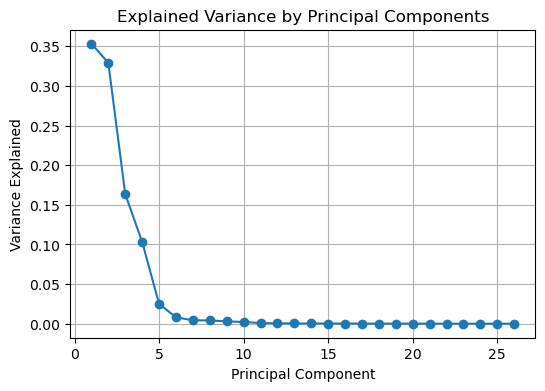

In [33]:
import matplotlib.pyplot as plt

X_pca, explained_variance, components = run_PCA(Xf, indices)


def scree_plot(explained_variance):
    plt.figure(figsize=(6,4))
    plt.plot(range(1, len(explained_variance)+1), explained_variance, marker='o')
    plt.title('Explained Variance by Principal Components')
    plt.xlabel('Principal Component')
    plt.ylabel('Variance Explained')
    plt.grid(True)
    plt.show()

scree_plot(explained_variance)


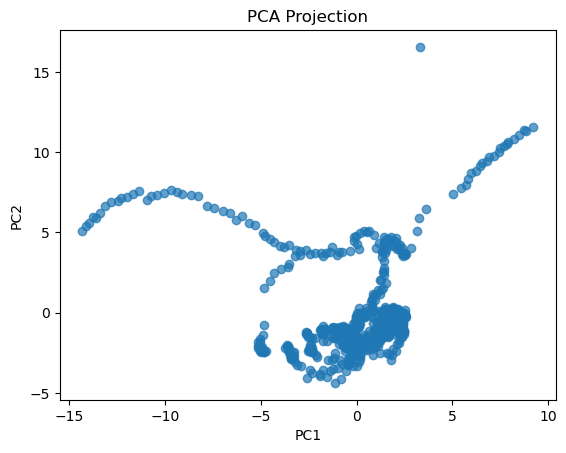

In [34]:
plt.scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.7)
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PCA Projection')
plt.show()


In [ ]:
for i, (idx, row) in enumerate(df_movements.iterrows()):
    
    base = row['dataset']  # like 'b1', 't2', etc.
    indices = row['indices']
    mov = row['movement']
    
    # Get front and side dataframes
    f = dataframes.get(base + 'f')
    s = dataframes.get(base + 's')

    both_view = [(base+"f", f), (base+"s", s)]

    for label, view in both_view:
        if view is None:
            print(f"Warning: Missing data for {base + label}. Skipping.")
            continue

        X_pca, explained_variance, components = run_PCA(view, indices, label, mov)
        # optionally: store or plot results here


Top contributing features to PC1 for b1f in movement hand_OC:
fTip5.1: 0.217
MCP5.1: 0.217
fTip4.1: 0.216
PalmBase.1: 0.216
fTip3.1: 0.215
Top contributing features to PC1 for b1s in movement hand_OC:
MidForeArm.1: 0.280
MCP2.1: 0.276
MCP3.1: 0.270
fTip2.1: 0.267
fTip3.1: 0.261
Top contributing features to PC1 for b1f in movement hand_PS:
fTip3: 0.210
PalmBase: 0.210
MCP2: 0.210
fTip2: 0.210
fTip4: 0.210
Top contributing features to PC1 for b1s in movement hand_PS:
MCP4.1: 0.246
MCP5.1: 0.241
PalmBase: 0.235
fTip4.1: 0.234
MCP3.1: 0.233
Top contributing features to PC1 for b1f in movement arm_EF:
MidForeArm.1: 0.203
Elbow: -0.203
Elbow.1: -0.203
PalmBase.1: 0.201
MCP4: -0.200
Top contributing features to PC1 for b1s in movement arm_EF:
fTip2: 0.206
fTip3: 0.205
MidForeArm.1: 0.205
MCP4: 0.204
fTip4: 0.204
Top contributing features to PC1 for b2f in movement hand_OC:
fTip3.1: 0.263
fTip4.1: 0.263
fTip2.1: 0.262
fTip5.1: 0.262
PalmBase.1: 0.259
Top contributing features to PC1 for b2s in

In [ ]:
X = df.drop('Gender', axis=1)
y = df['Gender']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(df)

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, random_state=42)

model = LogisticRegression()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Female', 'Male'], yticklabels=['Female', 'Male'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

y_numeric = pd.factorize(y)[0]

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.scatter(X_scaled[:, 0], X_scaled[:, 1], c=y_numeric, cmap='coolwarm', edgecolor='k', s=80)
plt.xlabel('Original Feature 1')
plt.ylabel('Original Feature 2')
plt.title('Before PCA: Using First 2 Standardized Features')
plt.colorbar(label='Target classes')

plt.subplot(1, 2, 2)
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_numeric, cmap='coolwarm', edgecolor='k', s=80)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('After PCA: Projected onto 2 Principal Components')
plt.colorbar(label='Target classes')

plt.tight_layout()
plt.show()

## Run PCA for whole movement

In [64]:

rows_front = []
rows_side = []

for i, (idx, row) in enumerate(df_movements.iterrows()):
    base = row['dataset']     # like 'b1', 't2'
    indices = row['indices']  # e.g., (1745, 2515)
    mov = row['movement']     # e.g., 'press', 'extend'

    # Get front and side dataframes
    f = dataframes.get(base + 'f')
    s = dataframes.get(base + 's')

    both_view = [(base + "f", f, "front"), (base + "s", s, "side")]

    for label, view, view_type in both_view:
        if view is None:
            print(f"Warning: Missing data for {label}. Skipping.")
            continue

        X_pca, explained_variance, components = run_PCA(view, indices, label, mov)


        for j in range(X_pca.shape[0]):
            row_dict = {
                "dataset": base,
                "movement": mov,
                "view": view_type,
            }
            # Add PC scores
            for pc_index in range(X_pca.shape[1]):
                row_dict[f"PC{pc_index + 1}"] = X_pca[j, pc_index]

            # Append to correct list
            if view_type == "front":
                rows_front.append(row_dict)
            else:
                rows_side.append(row_dict)


Top contributing features to PC1 for b1f in movement hand_OC:
MidForeArm.1: 0.280
MCP2.1: 0.276
MCP3.1: 0.270
fTip2.1: 0.267
fTip3.1: 0.261
Top contributing features to PC1 for b1s in movement hand_OC:
fTip3: 0.210
PalmBase: 0.210
MCP2: 0.210
fTip2: 0.210
fTip4: 0.210
Top contributing features to PC1 for b1f in movement hand_PS:
MCP4.1: 0.246
MCP5.1: 0.241
PalmBase: 0.235
fTip4.1: 0.234
MCP3.1: 0.233
Top contributing features to PC1 for b1s in movement hand_PS:
MidForeArm.1: 0.203
Elbow: -0.203
Elbow.1: -0.203
PalmBase.1: 0.201
MCP4: -0.200
Top contributing features to PC1 for b1f in movement arm_EF:
fTip2: 0.206
fTip3: 0.205
MidForeArm.1: 0.205
MCP4: 0.204
fTip4: 0.204
Top contributing features to PC1 for b1s in movement arm_EF:
fTip3.1: 0.263
fTip4.1: 0.263
fTip2.1: 0.262
fTip5.1: 0.262
PalmBase.1: 0.259
Top contributing features to PC1 for b2f in movement hand_OC:
MCP4: 0.229
MCP5.1: 0.226
MCP3: 0.224
MCP2: 0.221
fTip1: 0.220
Top contributing features to PC1 for b2s in movement hand

In [72]:
df_front = pd.DataFrame(rows_front)
df_side = pd.DataFrame(rows_side)

print(df_front.head())  # View first 5 rows of front PCA scores
print(df_side.head())   # View first 5 rows of side PCA scores



  dataset movement   view       PC1        PC2        PC3        PC4  \
0      b1  hand_OC  front  3.288216  16.558069 -50.309760  15.261665   
1      b1  hand_OC  front  8.767465  11.367021 -11.919882   4.246000   
2      b1  hand_OC  front  9.226313  11.538507   2.394152   0.088365   
3      b1  hand_OC  front  8.859834  11.333406   2.363870  -0.020548   
4      b1  hand_OC  front  8.483969  11.066099   2.272204  -0.151655   

         PC5       PC6       PC7  ...      PC17      PC18      PC19      PC20  \
0   5.820365  0.108424  0.085167  ...  0.021823 -0.007106  0.002389  0.010208   
1 -21.411326  0.366295 -0.010012  ... -0.009225  0.016649  0.012303  0.004225   
2   0.456722 -0.962719 -1.277489  ... -0.138490  0.120436  0.049308 -0.072160   
3   0.467274 -0.595024 -0.688666  ... -0.144503  0.065535 -0.029050 -0.089930   
4   0.470935 -0.904744 -1.174520  ... -0.037341 -0.019142 -0.071063  0.065052   

       PC21      PC22      PC23      PC24      PC25      PC26  
0 -0.012776  0.0

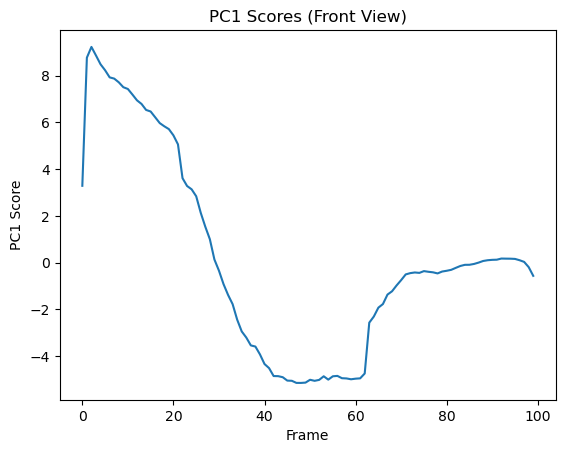

In [73]:

pc1_scores_front = df_front['PC1']
pc1_scores_side = df_side['PC1']

import matplotlib.pyplot as plt

# Plot PC1 for front view for first 100 frames
plt.plot(pc1_scores_front[:100])
plt.title("PC1 Scores (Front View)")
plt.xlabel("Frame")
plt.ylabel("PC1 Score")
plt.show()


In [68]:
def top_5_original_columns_by_mean(df):
    # Step A: Drop '.2' columns (e.g., likelihoods)
    df = df.loc[:, ~df.columns.str.contains(r'\.2')]

    # Step B: Drop metadata columns if they exist
    df = df.drop(columns=[col for col in ['dataset', 'movement', 'view'] if col in df.columns], errors='ignore')

    # Step C: Only keep numeric columns
    numeric_df = df.select_dtypes(include='number')

    # Step D: Calculate mean per column
    column_means = numeric_df.mean()

    # Step E: Sort and return top 5
    top_5 = column_means.sort_values(ascending=False).head(5)
    return column_means.to_dict(), top_5



In [70]:
column_means_front, top5_front = top_5_columns_by_mean(df_front)
column_means_side, top5_side = top_5_columns_by_mean(df_side)

print("Top 5 columns by average value (Front View):")
print(top5_front)

print("\nTop 5 columns by average value (Side View):")
print(top5_side)


Top 5 columns by average value (Front View):
PC5     9.341983e-18
PC14    9.033459e-18
PC7     6.780900e-18
PC9     6.157216e-18
PC12    5.944898e-18
dtype: float64

Top 5 columns by average value (Side View):
PC18    1.762112e-17
PC22    1.738987e-17
PC12    1.507739e-17
PC3     1.479989e-17
PC4     1.183991e-17
dtype: float64
